In [442]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np

# Use this script to gather results inside one subdirectory and plot them. Be sure to always to always start the script from the directory where the '0io', '1io', '2io' etc. directories are located.

In [443]:

# Define the base directory where the CSV files are located
# base_dir = '/home/fott/UniPPS/projekt/messungen/cp/r2b5/12m/n4joint/'  # Replace this with the actual path
base_dir = './messungen/cp/r2b6/12h/n2'  # Replace this with the actual path

# Initialize a list to hold the total averages and their corresponding process counts
data = []

# Iterate over the folders for IO and checkpoints
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    file_data = pd.DataFrame()
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Iterate over files in the directory
        for filename in os.listdir(folder_path):
            if filename.endswith('.csv'):
                csv_path = os.path.join(folder_path, filename)
                
                # Read the CSV file
                try:
                    df = pd.read_csv(csv_path, index_col=0)

                    filetype = 'io' if 'io' in filename else 'checkpoints' if 'checkpoints' in filename else 'workers'

                    total_avg = df.loc['total', 'total avg (s)'] if filename == 'timer_report_workers.csv' else 0
                    wrt_output_avg = df.loc['wrt_output', 'total avg (s)'] if not filename == 'timer_report_checkpoints.csv' else 0
                    wrt_restart_avg = df.loc['write_restart', 'total avg (s)'] if not filename == 'timer_report_io.csv' else 0

                    time_data = pd.Series((total_avg, wrt_output_avg, wrt_restart_avg), index=['total_avg', 'wrt_output_avg', 'wrt_restart_avg'], name=filetype)

                    # Append the value with the number of processes (extracted from the folder name)
                    file_data = pd.concat((file_data, time_data.to_frame().T), ignore_index=False)
                except Exception as e:
                    print(f'Error reading {csv_path}: {e}')

        data.append((re.sub(r'[a-z]+', '', folder), file_data))

        print(file_data.head())

             total_avg  wrt_output_avg  wrt_restart_avg
workers       2887.178           3.696           11.105
checkpoints      0.000           0.000          143.502
             total_avg  wrt_output_avg  wrt_restart_avg
workers       2939.524           3.737            3.951
checkpoints      0.000           0.000          103.767
             total_avg  wrt_output_avg  wrt_restart_avg
workers       2863.687            3.61            4.058
checkpoints      0.000            0.00          160.070
         total_avg  wrt_output_avg  wrt_restart_avg
workers   3044.304          11.333          181.237
             total_avg  wrt_output_avg  wrt_restart_avg
workers       2855.961           3.594            9.140
checkpoints      0.000           0.000          172.335


In [444]:
# Create a DataFrame from the collected data
results = pd.DataFrame(data, columns=['# processes', 'data'])

# Convert the 'Processes' to a categorical variable for proper sorting in the plot
results.sort_values('# processes', inplace=True, key=lambda x: x.astype(int))
results['# processes'] = results['# processes'].astype(str)

# results.head()
print(results['data'])
# print(data.head())

3             total_avg  wrt_output_avg  wrt_restar...
4                 total_avg  wrt_output_avg  wrt_re...
2                 total_avg  wrt_output_avg  wrt_re...
0                 total_avg  wrt_output_avg  wrt_re...
1                 total_avg  wrt_output_avg  wrt_re...
Name: data, dtype: object


In [445]:
# Read the CSV file "get_write_speed.csv"
write_speed_df = pd.read_csv(os.path.join(base_dir, 'get_write_speed.csv'), index_col=0, header=0)

# Display the first few rows of the dataframe
print(write_speed_df.head())

                 Get MB/s avg  Write MB/s avg
# dedicated PEs                              
0r                    0.00000         0.00000
1r                22101.26095       663.82865
2r                25151.59285       726.66670
4r                28705.99025       791.92640
8r                33479.38650      1126.31430


['0', '1', '2', '4', '8']


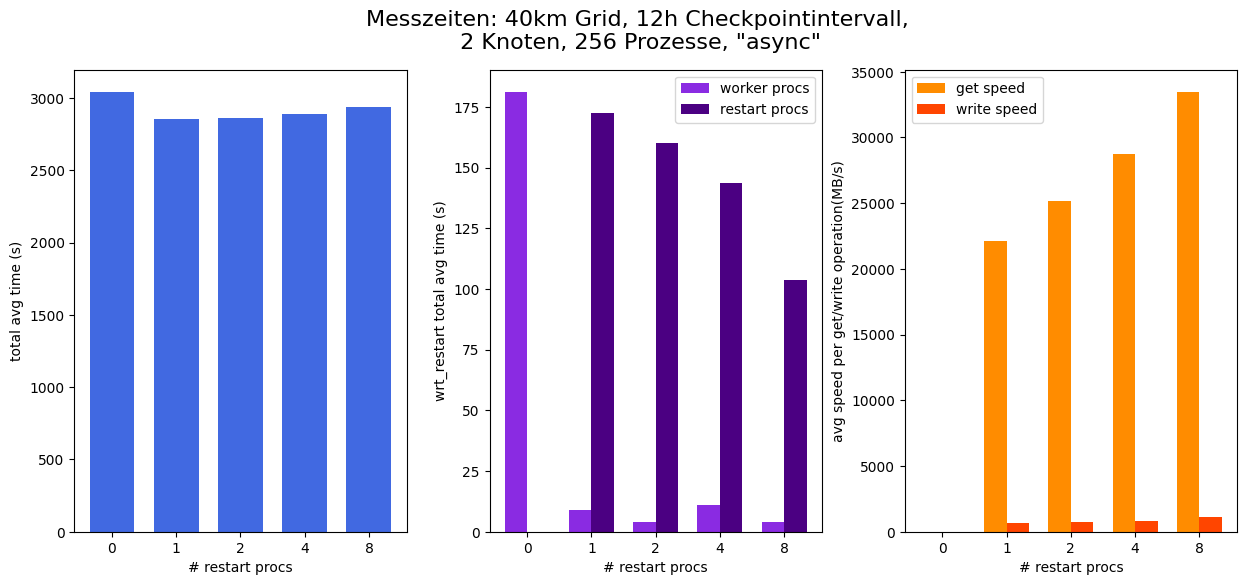

In [446]:

# Plotting the data
total = results['data'].apply(lambda x: x['total_avg']).fillna(0)
# print(total)
wrt_output = results['data'].apply(lambda x: x['wrt_output_avg']).fillna(0)
# print(wrt_output)
wrt_restart = results['data'].apply(lambda x: x['wrt_restart_avg']).fillna(0)
# print(wrt_restart)

# add values from joint mode manually when plotting dedicated mode results
# total.loc["joint"] = [334.673, 0]
# wrt_restart.loc["joint"] = [3.053, 0]
x_labels = results['# processes'].to_list()
# x_labels.append("n16joint")
print(x_labels)

# init plot
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
bar_width = 0.35
plt.subplots_adjust(wspace=0.25)
fig.suptitle('Messzeiten: 40km Grid, 12h Checkpointintervall,\n 2 Knoten, 256 Prozesse, "async"', fontsize=16)

# first subplot, total runtime
ax[0].bar(x_labels, total['workers'], color='royalblue', width=bar_width*2)
# switch to IO or restart Procs depending on what you want to analyzse
ax[0].set_xlabel('# restart procs')
ax[0].set_ylabel('total avg time (s)')

x = np.arange(len(x_labels))

# use for restart
ax[1].bar(x - bar_width/2, wrt_restart['workers'], color='blueviolet', width=bar_width)
ax[1].bar(x + bar_width/2 , wrt_restart['checkpoints'], color='indigo', width=bar_width)
ax[1].legend(['worker procs', 'restart procs'])
ax[1].set_xticks(x, x_labels)
ax[1].set_xlabel('# restart procs')
ax[1].set_ylabel('wrt_restart total avg time (s)')

# use for io
# ax[1].bar(x - bar_width/2, wrt_output['workers'], color='deepskyblue', width=bar_width)
# ax[1].bar(x + bar_width/2 , wrt_output['io'], color='turquoise', width=bar_width)
# ax[1].legend(['worker procs', 'io procs'])
# ax[1].set_xticks(x, results['# processes'])
# ax[1].set_xlabel('# IO procs')
# ax[1].set_ylabel('wrt_output total avg time (s)')

# dont use this for dedicated mode
ax[2].bar(x - bar_width/2, write_speed_df['Get MB/s avg'], color='darkorange', width=bar_width)
ax[2].bar(x + bar_width/2 , write_speed_df['Write MB/s avg'], color='orangered', width=bar_width)
ax[2].legend(['get speed', 'write speed'])
ax[2].set_xticks(x, results['# processes'])
ax[2].set_xlabel('# restart procs')
ax[2].set_ylabel('avg speed per get/write operation(MB/s)')

# # use this for dedicated mode
# ax[2].bar(x_labels, write_speed_df['Get MB/s avg'], color='orangered', width=bar_width*2)
# ax[2].set_xticks(x, x_labels)
# ax[2].set_xlabel('# restart procs')
# ax[2].set_ylabel('avg write speed (MB/s)')

plt.savefig(base_dir + 'messzeiten.png', format='png', dpi=300, )

plt.show()